In [1]:
import statsmodels as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping 

In [3]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

def rmse(y, y_pred):
    return mse(y, y_pred)**0.5

---------------------------------------------------------------

In [29]:
data = pd.read_csv("../data/서울대공원/서울대공원 네비게이션 유추.csv", encoding="cp949")
data["date"] = pd.to_datetime(data["date"])
data.set_index("date", inplace=True)

<AxesSubplot:xlabel='date'>

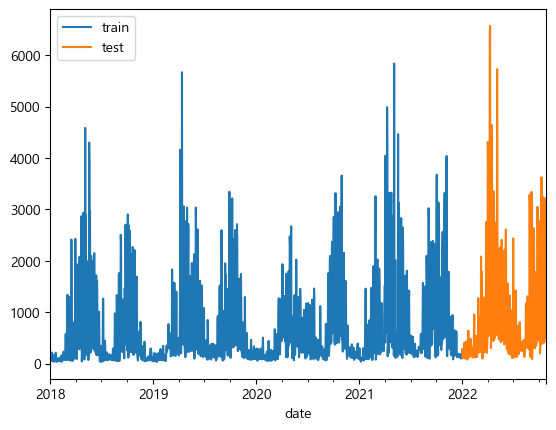

In [30]:
data_entrance=data[['네비게이션']]
split_date = pd.Timestamp('2022-01-01')
#학습용 데이터와 테스트용 데이터로 분리
train_data=pd.DataFrame(data_entrance.loc[:split_date,['네비게이션']])
test_data=pd.DataFrame(data_entrance.loc[split_date:,['네비게이션']])
#분리된 데이터 시각화
ax = train_data.plot()
test_data.plot(ax=ax)
plt.legend(['train', 'test'])

In [31]:
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler() 
train_data_sc = scaler.fit_transform(train_data)
test_data_sc= scaler.transform(test_data)

In [32]:
train_sc_df = pd.DataFrame(train_data_sc, columns=['Scaled'], index=train_data.index)
test_sc_df = pd.DataFrame(test_data_sc, columns=['Scaled'], index=test_data.index)

In [33]:
for i in range(1, 12):
    train_sc_df ['Scaled_{}'.format(i)]=train_sc_df ['Scaled'].shift(i)
    test_sc_df ['Scaled_{}'.format(i)]=test_sc_df ['Scaled'].shift(i)

In [34]:
x_train=train_sc_df.dropna().drop('Scaled', axis=1)
y_train=train_sc_df.dropna()[['Scaled']]

x_test=test_sc_df.dropna().drop('Scaled', axis=1)
y_test=test_sc_df.dropna()[['Scaled']]

x_train=x_train.values
x_test=x_test.values

y_train=y_train.values
y_test=y_test.values

x_train_t = x_train.reshape(x_train.shape[0], 11,1)
x_test_t = x_test.reshape(x_test.shape[0], 11, 1)
# 가중치

In [35]:
K.clear_session() 
# Sequeatial Model
model = Sequential() 
# 첫번째 LSTM 레이어
model.add(LSTM(30,return_sequences=True, input_shape=(11, 1))) 
# 두번째 LSTM 레이어
model.add(LSTM(42,return_sequences=False))  
# 예측값 1개
model.add(Dense(1, activation='linear')) 
# 손실함수 지정 - 예측 값과 실제 값의 차이를 계산한다. MSE가 사용된다. 
# 최적화기 지정 - 일반적으로 adam을 사용한다.
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 11, 30)            3840      
                                                                 
 lstm_1 (LSTM)               (None, 42)                12264     
                                                                 
 dense (Dense)               (None, 1)                 43        
                                                                 
Total params: 16,147
Trainable params: 16,147
Non-trainable params: 0
_________________________________________________________________


In [36]:
early_stop = EarlyStopping(monitor='loss', patience=15, verbose=1)

model.fit(x_train_t, y_train, epochs=200,
          batch_size=20, verbose=1, callbacks=[early_stop])

y_pred = model.predict(x_test_t)

Epoch 1/200
73/73 [==============================] - 7s 16ms/step - loss: 0.0166
Epoch 2/200
73/73 [==============================] - 1s 20ms/step - loss: 0.0153
Epoch 3/200
73/73 [==============================] - 1s 13ms/step - loss: 0.0153
Epoch 4/200
73/73 [==============================] - 1s 16ms/step - loss: 0.0149
Epoch 5/200
73/73 [==============================] - 1s 15ms/step - loss: 0.0140
Epoch 6/200
73/73 [==============================] - 1s 16ms/step - loss: 0.0131
Epoch 7/200
73/73 [==============================] - 2s 21ms/step - loss: 0.0126
Epoch 8/200
73/73 [==============================] - 1s 19ms/step - loss: 0.0123
Epoch 9/200
73/73 [==============================] - 1s 17ms/step - loss: 0.0122
Epoch 10/200
73/73 [==============================] - 1s 15ms/step - loss: 0.0119
Epoch 11/200
73/73 [==============================] - 1s 20ms/step - loss: 0.0117
Epoch 12/200
73/73 [==============================] - 1s 20ms/step - loss: 0.0115
Epoch 13/200
73/73 [=====

73/73 [==============================] - 2s 21ms/step - loss: 0.0092
Epoch 102/200
73/73 [==============================] - 2s 22ms/step - loss: 0.0092
Epoch 103/200
73/73 [==============================] - 1s 16ms/step - loss: 0.0092
Epoch 104/200
73/73 [==============================] - 1s 20ms/step - loss: 0.0093
Epoch 105/200
73/73 [==============================] - 1s 17ms/step - loss: 0.0093
Epoch 106/200
73/73 [==============================] - 1s 18ms/step - loss: 0.0093
Epoch 107/200
73/73 [==============================] - 1s 20ms/step - loss: 0.0092
Epoch 108/200
73/73 [==============================] - 2s 21ms/step - loss: 0.0093
Epoch 109/200
73/73 [==============================] - 2s 20ms/step - loss: 0.0093
Epoch 110/200
73/73 [==============================] - 1s 17ms/step - loss: 0.0094
Epoch 111/200
73/73 [==============================] - 1s 18ms/step - loss: 0.0092
Epoch 112/200
73/73 [==============================] - 1s 17ms/step - loss: 0.0092
Epoch 113/200
73/7

73/73 [==============================] - 2s 31ms/step - loss: 0.0077
Epoch 200/200
73/73 [==============================] - 2s 23ms/step - loss: 0.0076


9/9 [==============================] - 4s 7ms/step


<AxesSubplot:xlabel='date'>

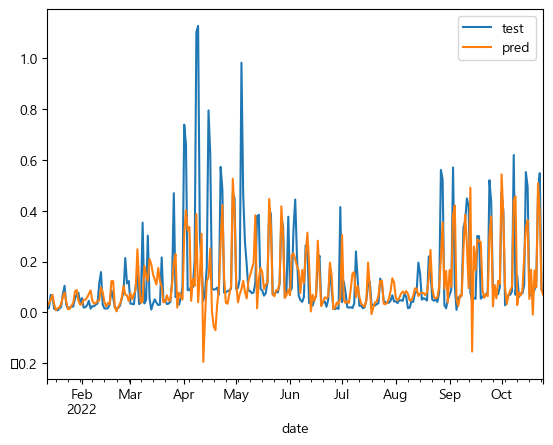

In [37]:
t_df=test_sc_df.dropna()
y_test_df=pd.DataFrame(y_test, columns=['entrance'], index=t_df.index)
y_pred_df=pd.DataFrame(y_pred, columns=['entrance'], index=t_df.index)

ax1=y_test_df.plot()
y_pred_df.plot(ax=ax1)
plt.legend(['test','pred'])


In [38]:
y_pred_df["원래값"]= y_pred_df["entrance"] * (max(test_data["네비게이션"])-min(test_data["네비게이션"])) + min(test_data["네비게이션"])
y_test_df["원래값"]= y_test_df["entrance"] * (max(test_data["네비게이션"])-min(test_data["네비게이션"])) + min(test_data["네비게이션"])

<AxesSubplot:xlabel='date'>

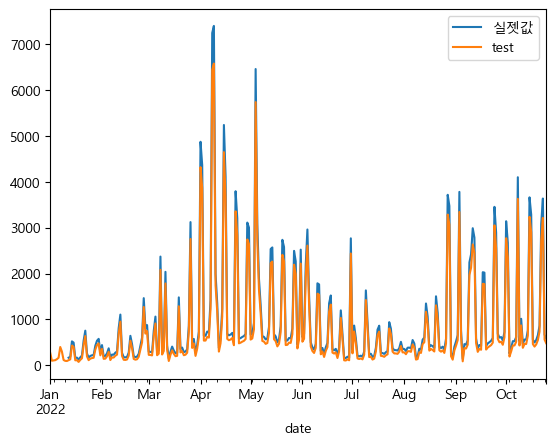

In [39]:
ax1=y_test_df["원래값"].plot()
test_data.plot(ax=ax1)
plt.legend(["실젯값",'test'])
# minmax 실제값으로 치환했을때 차이있는지 확인... 이건 완전히 같게 나오는게 맞음!

#### 모듈 저장 및 불러오기

In [40]:
from keras.models import load_model
model.save('seoulgp_model.h5')
model = load_model('seoulgp_model.h5')

In [41]:
index_list = []

for i in range(7):
    index_list.append(test_sc_df.index[-1] + pd.DateOffset(days=i+1))

In [42]:
last_days = y_test_df.iloc[-11:]["entrance"].values.reshape(1,11,1)

predict_entrance = []

for i in range(1,8):
    i=i+1
    last_day= model.predict(last_days)
    predict_entrance.append(list(last_day[0]))
    last_days = np.delete(last_days[0], 0,0)
    last_days = np.append(last_days,last_day)
    last_days = last_days.reshape(1,11,1)

1/1 [==============================] - 0s 42ms/step


In [43]:
pred_pred_df = pd.DataFrame(predict_entrance, columns=["entrance"], index=index_list)

<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

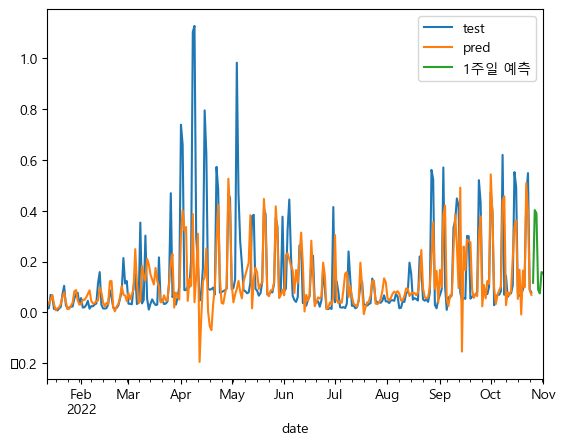

In [44]:
t_df=test_sc_df.dropna()
y_test_df=pd.DataFrame(y_test, columns=['entrance'], index=t_df.index)
y_pred_df=pd.DataFrame(y_pred, columns=['entrance'], index=t_df.index)

ax1=y_test_df.plot()
y_pred_df.plot(ax=ax1)
pred_pred_df.plot(ax=ax1)
plt.legend(['test','pred',"1주일 예측"])


In [46]:
pred_pred_df

,entrance
2022-10-26,0.116458
2022-10-27,0.402177
2022-10-28,0.390168
2022-10-29,0.089203
2022-10-30,0.074846
2022-10-31,0.158759
2022-11-01,0.152881
